# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_n\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{\frac{1}{p}}}{n^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


____

# 1. Global Config

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 100                       # Differential privacy level.
M = 200                          # Number of data points.
N = 20                           # Number of support points.
DIM = 2                          # Dimension of data.
STEP_SIZE = 5e-4                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [3]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=200 data points with dimension DIM=2


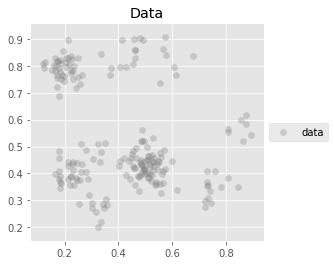

In [4]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    mus = data['MUS']
    weights = data['WEIGHTS']
    sigma_data = data['SIGMA_DATA']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:, 0], x[:, 1], c="gray", alpha=0.3,
                label='data')
    #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
    #            label='true centroids')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Data')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

___

# 3. Run Support Point Optimization

is_tf: True, y_init: radial, clip: bounds, weights: False

  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0043


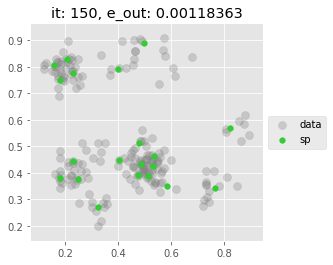

  [*] Overall it/s: 0.0048


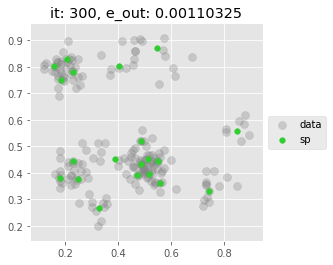

In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Define sensitivity.

In [6]:
# Define energy sensitivity for Exponential Mechanism.
# OLD: energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N + 2 * DIM ** (1. / ENERGY_POWER) * (N - 1) / N ** 2
print(('Laplace(2 * U / alpha) = Laplace(2 * {:.4f} / {:.2f}) '
       '= Laplace({:.3f})').format(energy_sensitivity, ALPHA, 
                                   2. * energy_sensitivity / ALPHA))

Laplace(2 * U / alpha) = Laplace(2 * 0.2758 / 100.00) = Laplace(0.006)


___

# 5. Sample support points.



--------- RUNNING DIFFUSION ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 100.000) = Exp(0.0055)

Diffusion count   137, e_opt:  0.001103, e~: 0.001861, energy(y,y~): 0.001887, error%: 0.013668


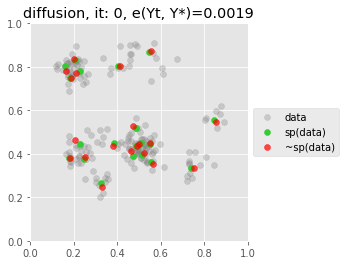

Diffusion count    66, e_opt:  0.001103, e~: 0.001319, energy(y,y~): 0.001346, error%: 0.021130


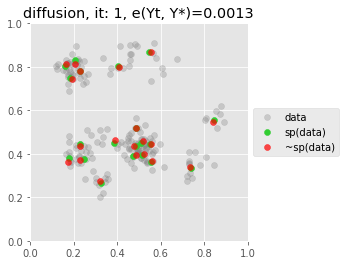

Diffusion count   710, e_opt:  0.001103, e~: 0.003765, energy(y,y~): 0.003777, error%: 0.003194


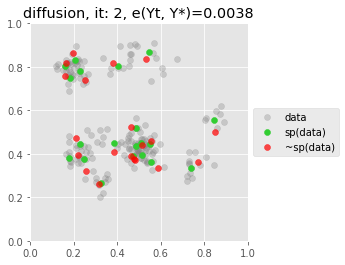

Diffusion count   188, e_opt:  0.001103, e~: 0.002203, energy(y,y~): 0.002272, error%: 0.031622


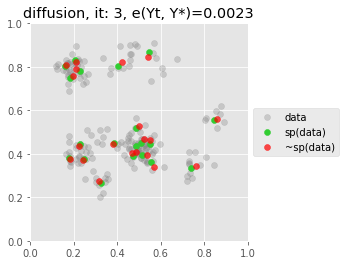

Diffusion count     2, e_opt:  0.001103, e~: 0.000148, energy(y,y~): 0.000183, error%: 0.233534


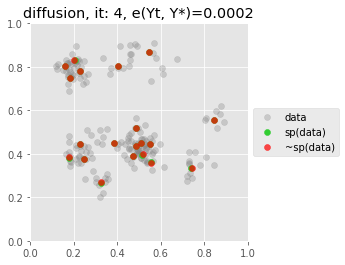

Diffusion count  4314, e_opt:  0.001103, e~: 0.018469, energy(y,y~): 0.018502, error%: 0.001760


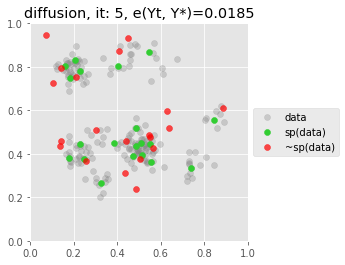

Diffusion count     3, e_opt:  0.001103, e~: 0.000317, energy(y,y~): 0.000340, error%: 0.071564


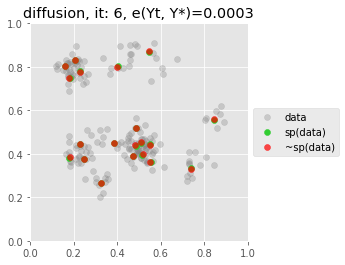

Diffusion count   148, e_opt:  0.001103, e~: 0.001903, energy(y,y~): 0.001924, error%: 0.011046


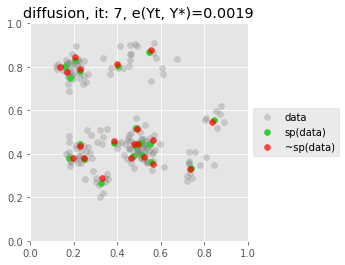

Diffusion count  4234, e_opt:  0.001103, e~: 0.017043, energy(y,y~): 0.017163, error%: 0.007049


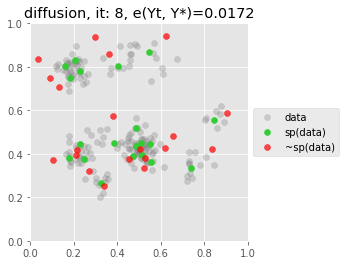

Diffusion count  4528, e_opt:  0.001103, e~: 0.018294, energy(y,y~): 0.018297, error%: 0.000137


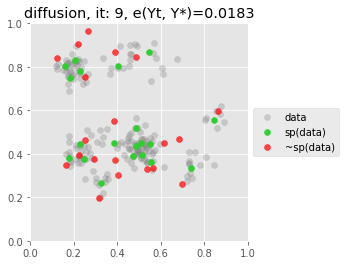

Diffusion count     1, e_opt:  0.001103, e~: 0.000130, energy(y,y~): 0.000143, error%: 0.102447


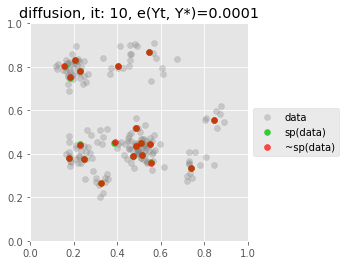

Diffusion count    86, e_opt:  0.001103, e~: 0.001577, energy(y,y~): 0.001627, error%: 0.032219


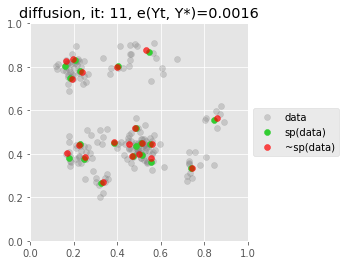

Diffusion count     1, e_opt:  0.001103, e~: 0.000087, energy(y,y~): 0.000185, error%: 1.119003


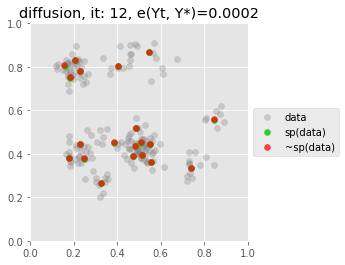

Diffusion count     8, e_opt:  0.001103, e~: 0.000376, energy(y,y~): 0.000395, error%: 0.049408


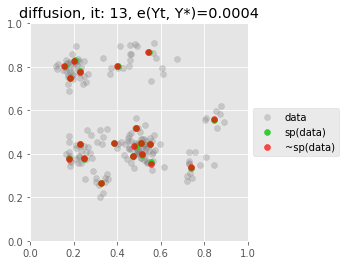

Diffusion count     4, e_opt:  0.001103, e~: 0.000287, energy(y,y~): 0.000314, error%: 0.094321


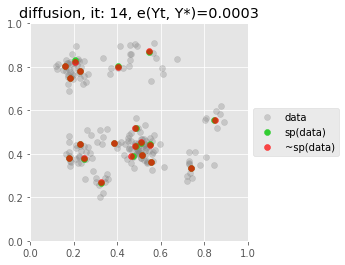

Diffusion count  2037, e_opt:  0.001103, e~: 0.009597, energy(y,y~): 0.009652, error%: 0.005739


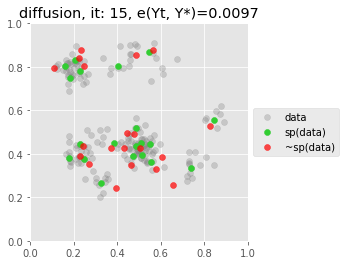

Diffusion count     1, e_opt:  0.001103, e~: 0.000026, energy(y,y~): 0.000184, error%: 5.984570


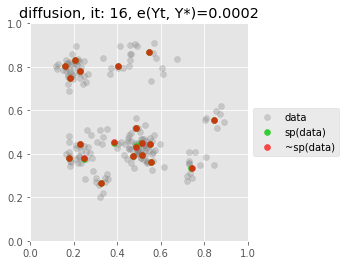

Diffusion count   211, e_opt:  0.001103, e~: 0.002376, energy(y,y~): 0.002393, error%: 0.007140


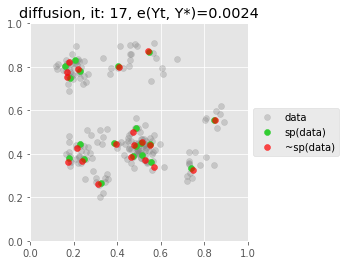

Diffusion count     2, e_opt:  0.001103, e~: 0.000207, energy(y,y~): 0.000256, error%: 0.237267


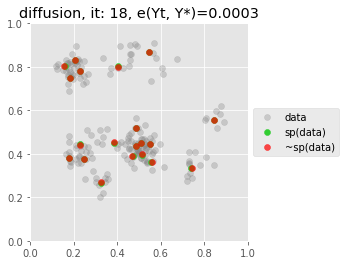

Diffusion count     2, e_opt:  0.001103, e~: 0.000237, energy(y,y~): 0.000262, error%: 0.102034


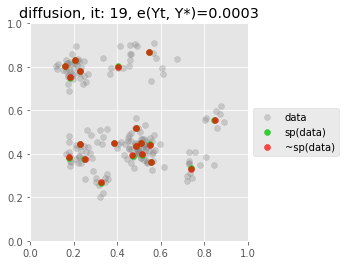

Diffusion count    15, e_opt:  0.001103, e~: 0.000741, energy(y,y~): 0.000795, error%: 0.072358


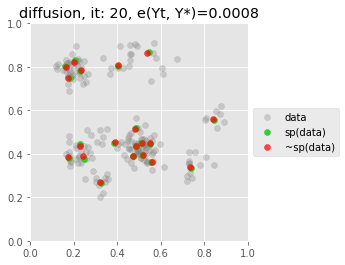

Diffusion count   993, e_opt:  0.001103, e~: 0.005073, energy(y,y~): 0.005089, error%: 0.003180


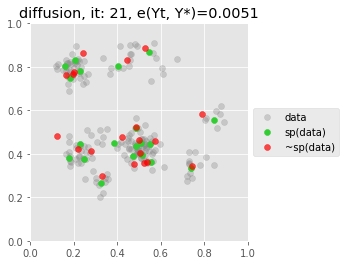

Diffusion count    39, e_opt:  0.001103, e~: 0.000960, energy(y,y~): 0.000972, error%: 0.012340


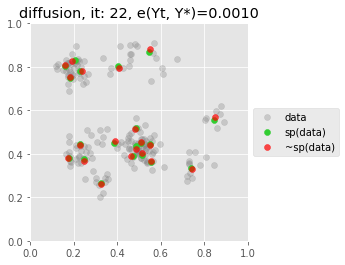

Diffusion count   612, e_opt:  0.001103, e~: 0.003682, energy(y,y~): 0.003693, error%: 0.003142


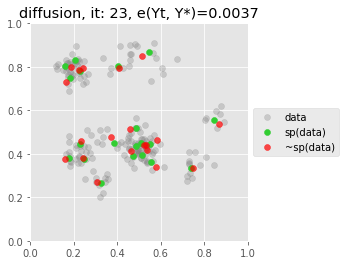

Diffusion count    11, e_opt:  0.001103, e~: 0.000663, energy(y,y~): 0.000664, error%: 0.001980


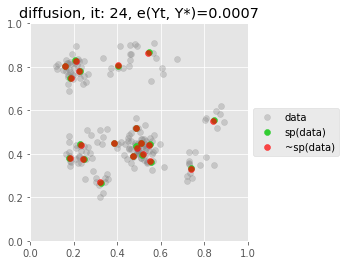

Diffusion count   848, e_opt:  0.001103, e~: 0.004124, energy(y,y~): 0.004131, error%: 0.001570


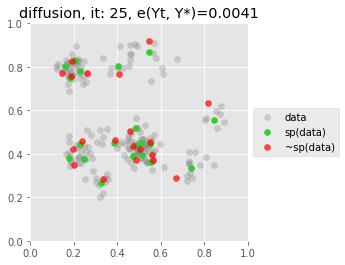

Diffusion count   204, e_opt:  0.001103, e~: 0.002000, energy(y,y~): 0.002005, error%: 0.002186


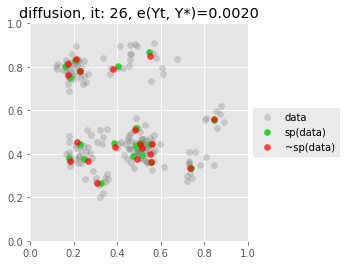

Diffusion count  5603, e_opt:  0.001103, e~: 0.016583, energy(y,y~): 0.016657, error%: 0.004515


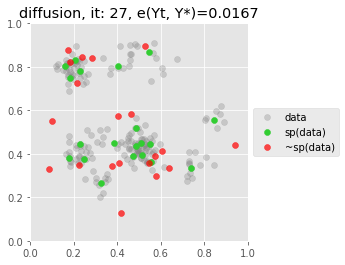

Diffusion count   261, e_opt:  0.001103, e~: 0.003298, energy(y,y~): 0.003334, error%: 0.010907


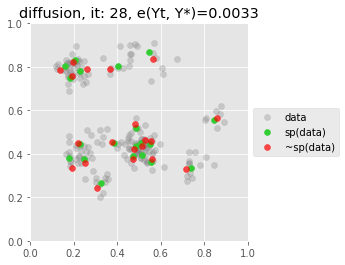

Diffusion count  1512, e_opt:  0.001103, e~: 0.008023, energy(y,y~): 0.008028, error%: 0.000506


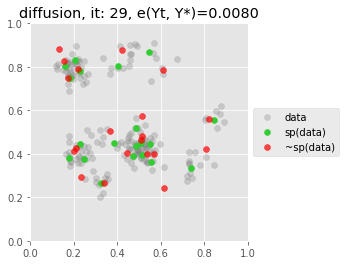

Diffusion count  2423, e_opt:  0.001103, e~: 0.006687, energy(y,y~): 0.006793, error%: 0.015812


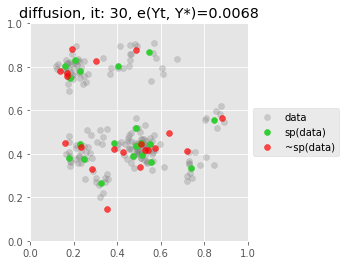

Diffusion count   618, e_opt:  0.001103, e~: 0.003849, energy(y,y~): 0.003854, error%: 0.001387


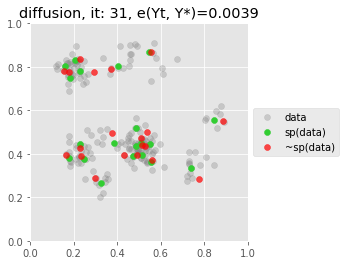

Diffusion count  7696, e_opt:  0.001103, e~: 0.014589, energy(y,y~): 0.014747, error%: 0.010836


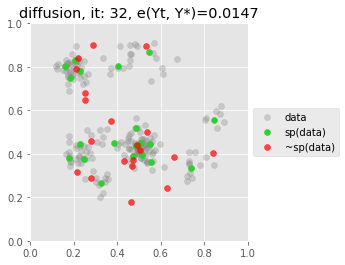

Diffusion count    97, e_opt:  0.001103, e~: 0.001938, energy(y,y~): 0.001945, error%: 0.003819


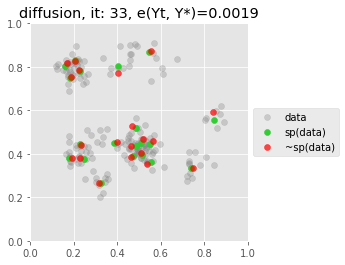

Diffusion count  3704, e_opt:  0.001103, e~: 0.015437, energy(y,y~): 0.015526, error%: 0.005737


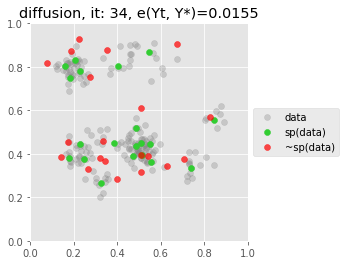

Diffusion count  4450, e_opt:  0.001103, e~: 0.017773, energy(y,y~): 0.017829, error%: 0.003178


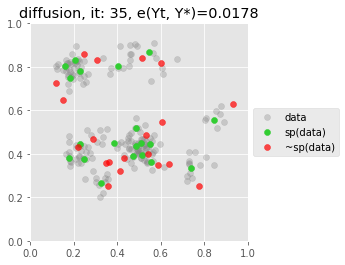

Diffusion count   111, e_opt:  0.001103, e~: 0.001211, energy(y,y~): 0.001237, error%: 0.021558


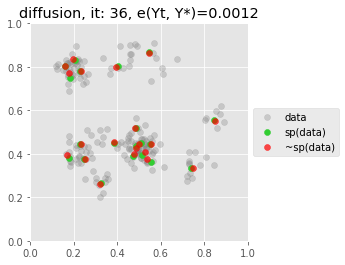

Diffusion count   252, e_opt:  0.001103, e~: 0.003316, energy(y,y~): 0.003318, error%: 0.000521


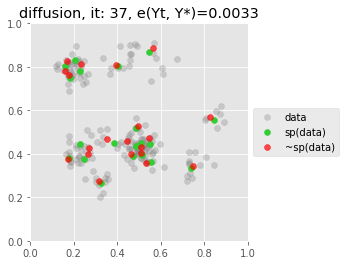

Diffusion count   137, e_opt:  0.001103, e~: 0.002870, energy(y,y~): 0.002879, error%: 0.003365


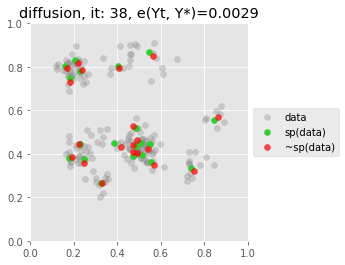

Diffusion count     1, e_opt:  0.001103, e~: 0.000116, energy(y,y~): 0.000210, error%: 0.807529


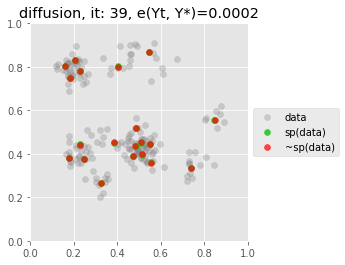

Diffusion count   787, e_opt:  0.001103, e~: 0.005247, energy(y,y~): 0.005298, error%: 0.009628


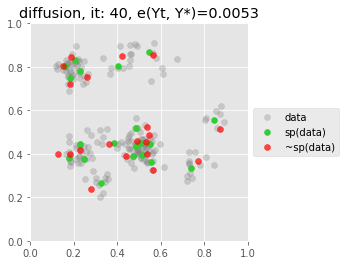

Diffusion count   419, e_opt:  0.001103, e~: 0.004010, energy(y,y~): 0.004052, error%: 0.010436


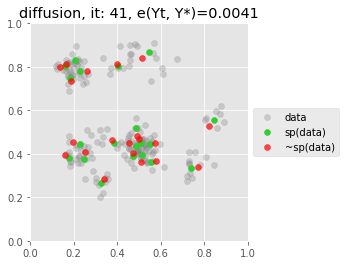

Diffusion count  1805, e_opt:  0.001103, e~: 0.006121, energy(y,y~): 0.006138, error%: 0.002728


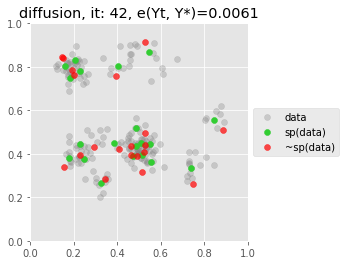

Diffusion count     3, e_opt:  0.001103, e~: 0.000263, energy(y,y~): 0.000286, error%: 0.090147


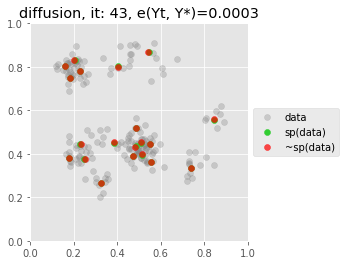

Diffusion count   642, e_opt:  0.001103, e~: 0.004721, energy(y,y~): 0.004723, error%: 0.000453


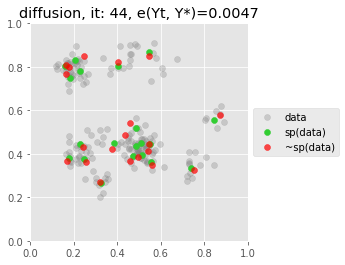

Diffusion count     7, e_opt:  0.001103, e~: 0.000407, energy(y,y~): 0.000420, error%: 0.030927


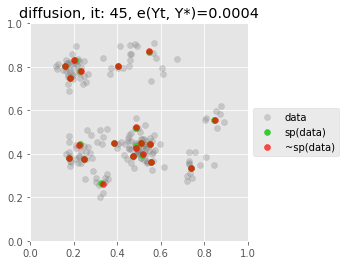

Diffusion count  3842, e_opt:  0.001103, e~: 0.009002, energy(y,y~): 0.009048, error%: 0.005086


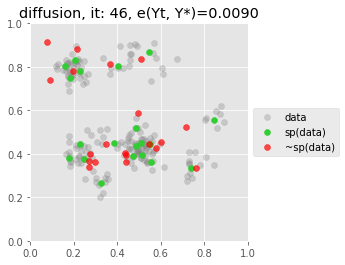

Diffusion count   587, e_opt:  0.001103, e~: 0.006305, energy(y,y~): 0.006397, error%: 0.014568


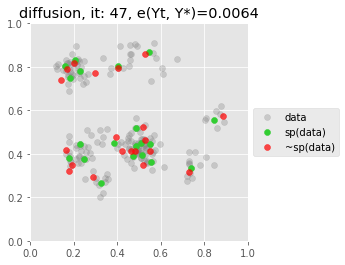

Diffusion count  5226, e_opt:  0.001103, e~: 0.015198, energy(y,y~): 0.015230, error%: 0.002094


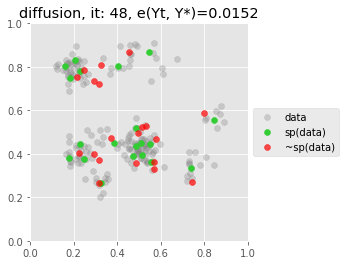

Diffusion count   949, e_opt:  0.001103, e~: 0.006793, energy(y,y~): 0.006817, error%: 0.003437


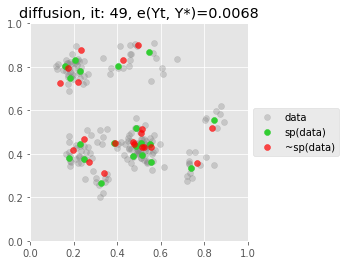

Diffusion count   672, e_opt:  0.001103, e~: 0.005473, energy(y,y~): 0.005504, error%: 0.005594


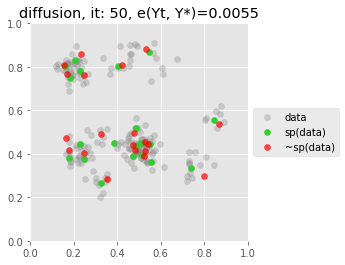

Diffusion count  1388, e_opt:  0.001103, e~: 0.005416, energy(y,y~): 0.005464, error%: 0.008858


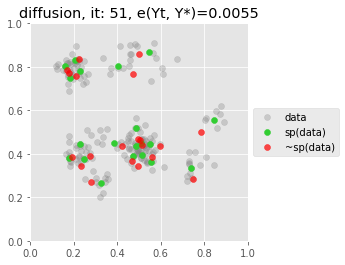

Diffusion count   932, e_opt:  0.001103, e~: 0.004435, energy(y,y~): 0.004461, error%: 0.005966


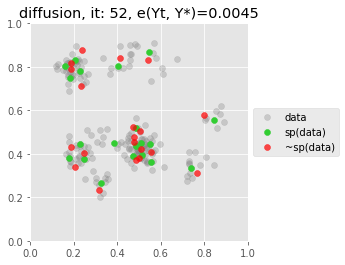

Diffusion count   540, e_opt:  0.001103, e~: 0.004386, energy(y,y~): 0.004390, error%: 0.000757


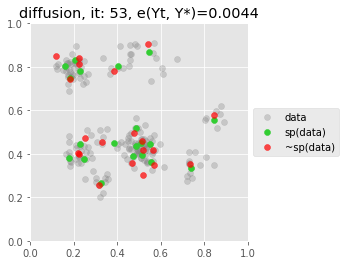

Diffusion count   299, e_opt:  0.001103, e~: 0.002814, energy(y,y~): 0.002835, error%: 0.007480


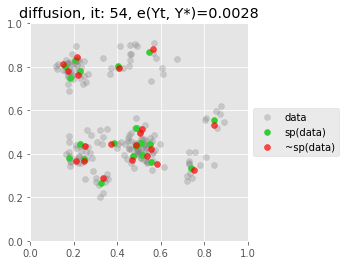

Diffusion count     3, e_opt:  0.001103, e~: 0.000266, energy(y,y~): 0.000324, error%: 0.220096


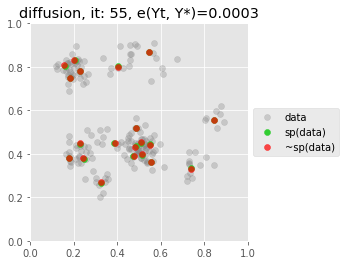

Diffusion count   266, e_opt:  0.001103, e~: 0.003339, energy(y,y~): 0.003341, error%: 0.000808


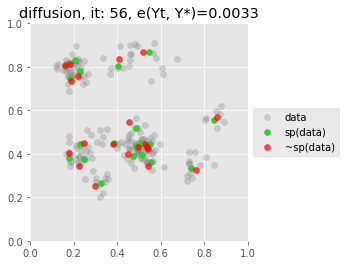

Diffusion count     1, e_opt:  0.001103, e~: 0.000019, energy(y,y~): 0.000163, error%: 7.762216


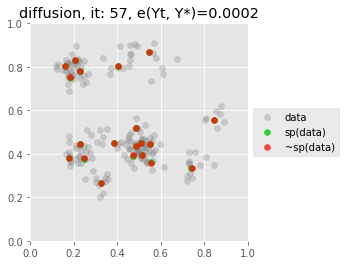

Diffusion count   171, e_opt:  0.001103, e~: 0.002212, energy(y,y~): 0.002235, error%: 0.010445


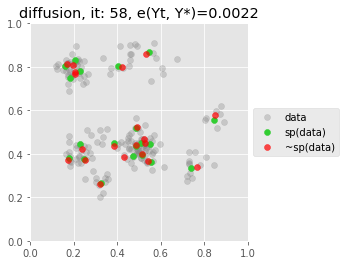

Diffusion count     7, e_opt:  0.001103, e~: 0.000404, energy(y,y~): 0.000449, error%: 0.111489


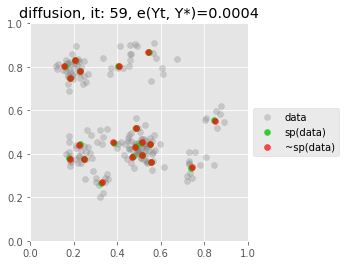

Diffusion count     1, e_opt:  0.001103, e~: 0.000033, energy(y,y~): 0.000127, error%: 2.845740


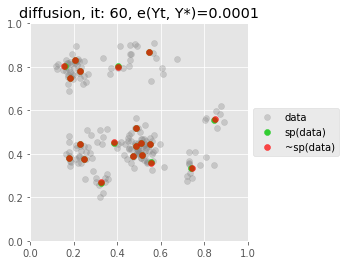

Diffusion count  2646, e_opt:  0.001103, e~: 0.007892, energy(y,y~): 0.007947, error%: 0.006946


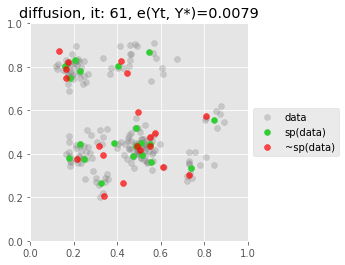

Diffusion count     2, e_opt:  0.001103, e~: 0.000194, energy(y,y~): 0.000242, error%: 0.247067


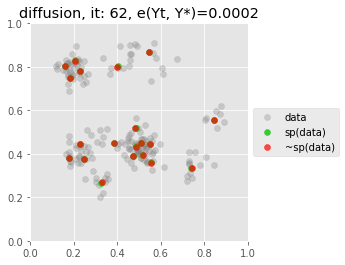

Diffusion count  1797, e_opt:  0.001103, e~: 0.007022, energy(y,y~): 0.007095, error%: 0.010363


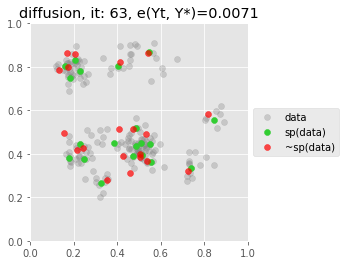

Diffusion count    95, e_opt:  0.001103, e~: 0.001915, energy(y,y~): 0.001973, error%: 0.030635


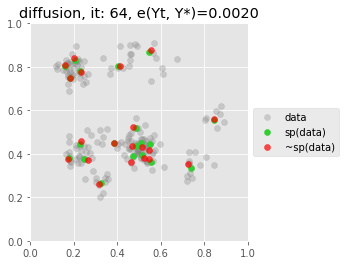

Diffusion count   966, e_opt:  0.001103, e~: 0.006126, energy(y,y~): 0.006155, error%: 0.004781


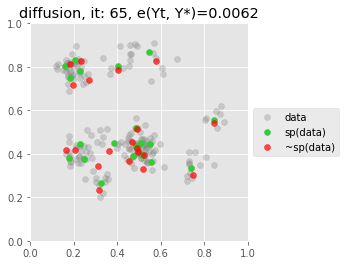

Diffusion count   423, e_opt:  0.001103, e~: 0.003040, energy(y,y~): 0.003065, error%: 0.008333


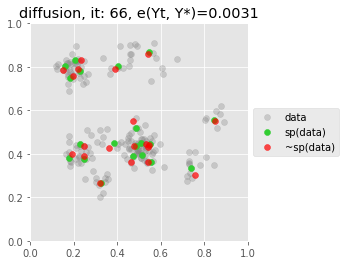

Diffusion count  3646, e_opt:  0.001103, e~: 0.011445, energy(y,y~): 0.011446, error%: 0.000116


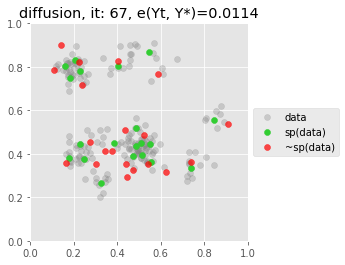

Diffusion count   153, e_opt:  0.001103, e~: 0.002251, energy(y,y~): 0.002257, error%: 0.002561


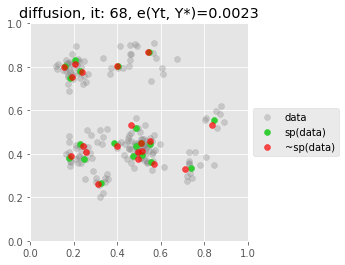

Diffusion count   269, e_opt:  0.001103, e~: 0.002828, energy(y,y~): 0.002907, error%: 0.028025


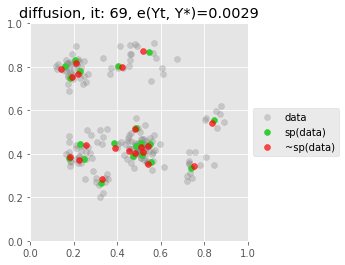

Diffusion count  1203, e_opt:  0.001103, e~: 0.008084, energy(y,y~): 0.008087, error%: 0.000306


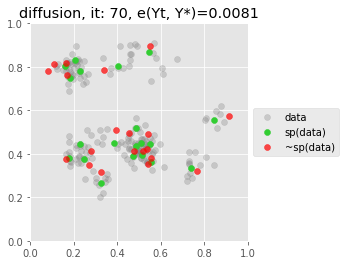

Diffusion count  9194, e_opt:  0.001103, e~: 0.024616, energy(y,y~): 0.024628, error%: 0.000452


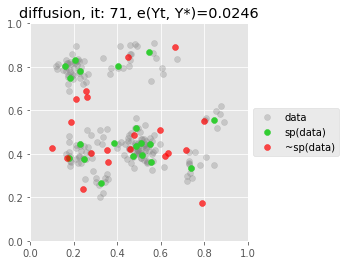

Diffusion count   691, e_opt:  0.001103, e~: 0.006311, energy(y,y~): 0.006388, error%: 0.012198


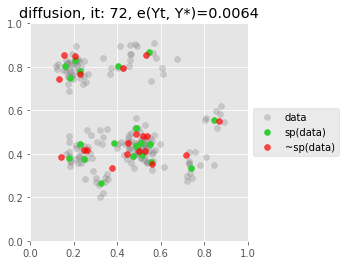

Diffusion count     9, e_opt:  0.001103, e~: 0.000506, energy(y,y~): 0.000520, error%: 0.027698


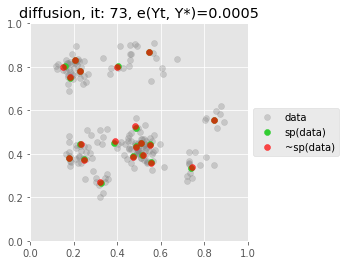

Diffusion count  3290, e_opt:  0.001103, e~: 0.011369, energy(y,y~): 0.011440, error%: 0.006247


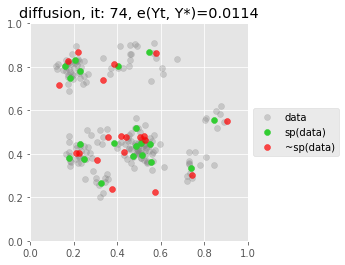

Diffusion count    66, e_opt:  0.001103, e~: 0.001472, energy(y,y~): 0.001477, error%: 0.003600


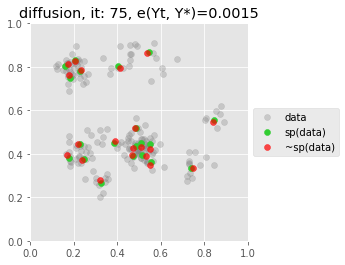

Diffusion count   150, e_opt:  0.001103, e~: 0.001905, energy(y,y~): 0.001913, error%: 0.004205


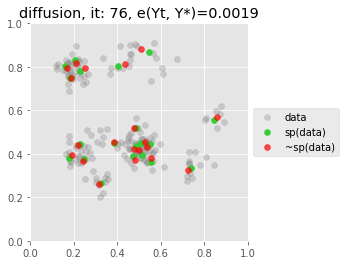

Diffusion count    19, e_opt:  0.001103, e~: 0.000725, energy(y,y~): 0.000730, error%: 0.006795


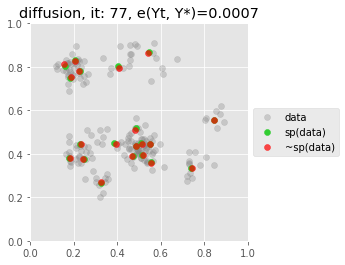

Diffusion count  1674, e_opt:  0.001103, e~: 0.007249, energy(y,y~): 0.007353, error%: 0.014389


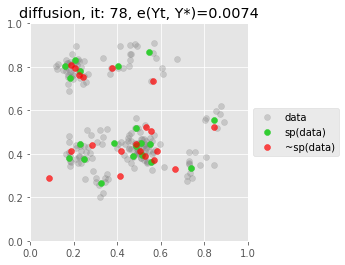

Diffusion count  3908, e_opt:  0.001103, e~: 0.008848, energy(y,y~): 0.008901, error%: 0.006081


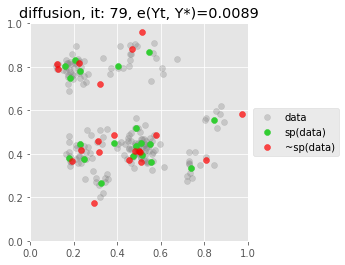

Diffusion count   133, e_opt:  0.001103, e~: 0.002486, energy(y,y~): 0.002617, error%: 0.052822


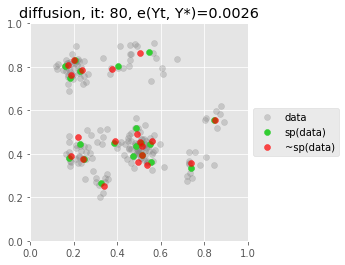

Diffusion count    70, e_opt:  0.001103, e~: 0.001470, energy(y,y~): 0.001523, error%: 0.035638


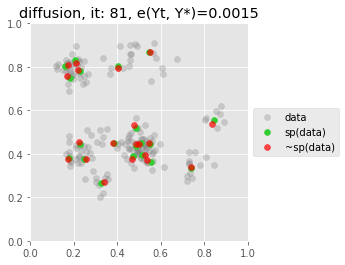

Diffusion count  8262, e_opt:  0.001103, e~: 0.014413, energy(y,y~): 0.014614, error%: 0.013924


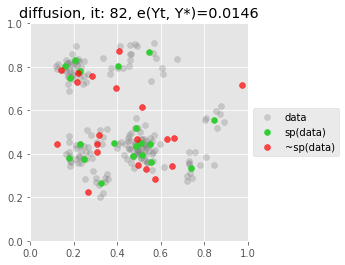

Diffusion count   854, e_opt:  0.001103, e~: 0.006568, energy(y,y~): 0.006616, error%: 0.007236


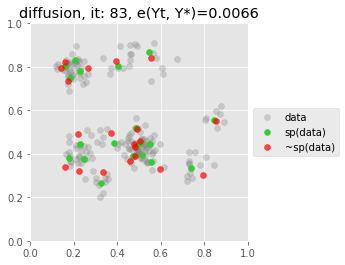

Diffusion count   234, e_opt:  0.001103, e~: 0.002889, energy(y,y~): 0.002890, error%: 0.000098


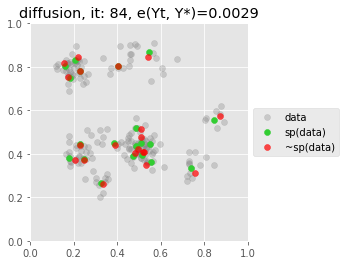

Diffusion count 23485, e_opt:  0.001103, e~: 0.033144, energy(y,y~): 0.033217, error%: 0.002185


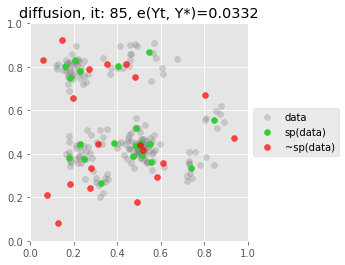

Diffusion count    35, e_opt:  0.001103, e~: 0.000879, energy(y,y~): 0.000885, error%: 0.006943


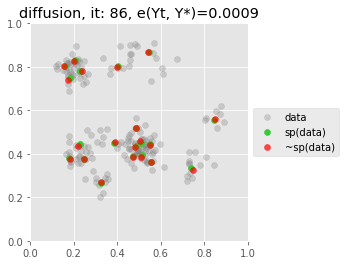

Diffusion count  2180, e_opt:  0.001103, e~: 0.008001, energy(y,y~): 0.008060, error%: 0.007388


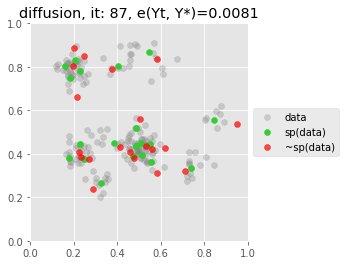

Diffusion count     1, e_opt:  0.001103, e~: 0.000017, energy(y,y~): 0.000193, error%: 10.324026


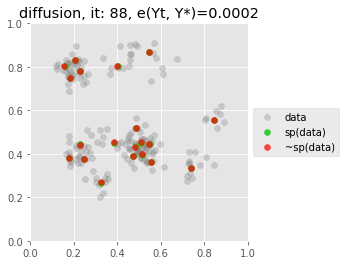

Diffusion count   319, e_opt:  0.001103, e~: 0.002680, energy(y,y~): 0.002688, error%: 0.002960


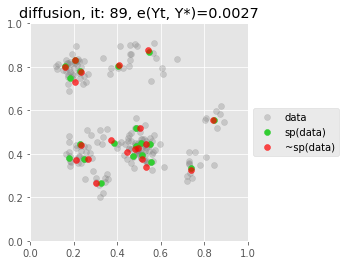

Diffusion count     7, e_opt:  0.001103, e~: 0.000440, energy(y,y~): 0.000447, error%: 0.014501


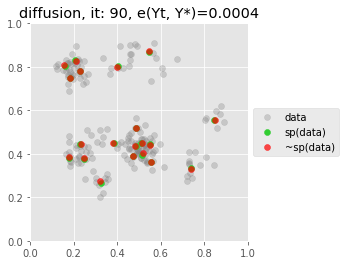

Diffusion count   247, e_opt:  0.001103, e~: 0.002463, energy(y,y~): 0.002514, error%: 0.020859


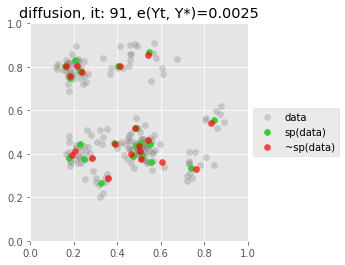

Diffusion count   415, e_opt:  0.001103, e~: 0.003295, energy(y,y~): 0.003378, error%: 0.024999


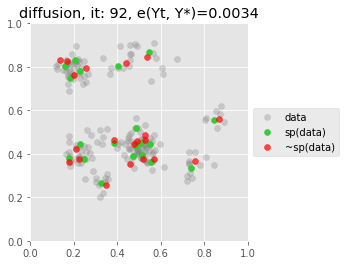

Diffusion count   191, e_opt:  0.001103, e~: 0.003136, energy(y,y~): 0.003202, error%: 0.021244


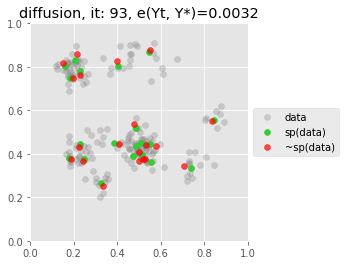

Diffusion count  1320, e_opt:  0.001103, e~: 0.005017, energy(y,y~): 0.005051, error%: 0.006781


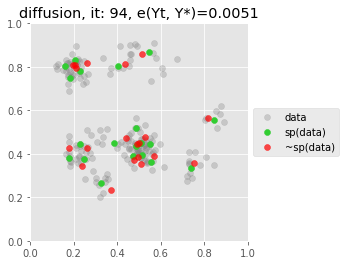

Diffusion count  6237, e_opt:  0.001103, e~: 0.011981, energy(y,y~): 0.012018, error%: 0.003094


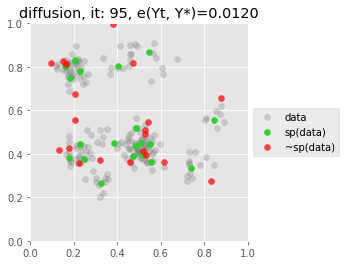

Diffusion count   229, e_opt:  0.001103, e~: 0.002860, energy(y,y~): 0.002918, error%: 0.020595


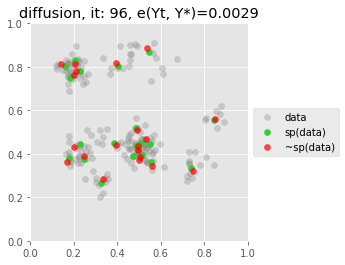

Diffusion count   284, e_opt:  0.001103, e~: 0.003679, energy(y,y~): 0.003735, error%: 0.015409


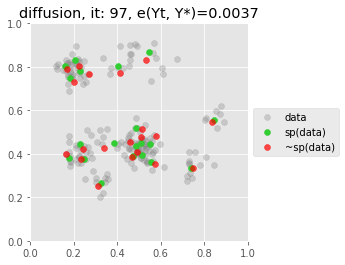

Diffusion count   527, e_opt:  0.001103, e~: 0.003632, energy(y,y~): 0.003638, error%: 0.001728


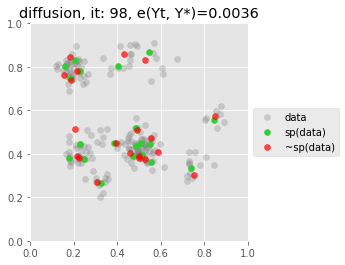

Diffusion count  1162, e_opt:  0.001103, e~: 0.004891, energy(y,y~): 0.004934, error%: 0.008906


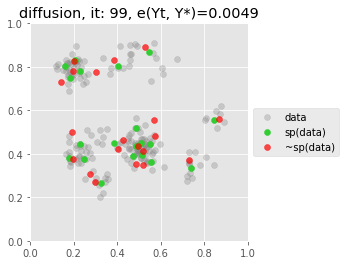

In [15]:
# Sampling parameters.
STEP_SIZE = 1e-3
NUM_Y_TILDES = 100

RUN_MH = 0
RUN_DIFFUSION = 1
PLOT = 1

if RUN_MH:
    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                       METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                       alpha=ALPHA)

if RUN_DIFFUSION:
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                              METHOD, STEP_SIZE, NUM_Y_TILDES,
                                              alpha=ALPHA)

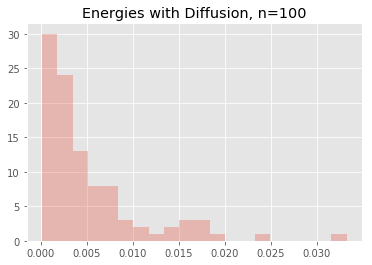

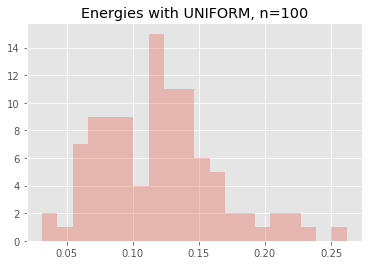

In [16]:
# Plot results of sampling for private support points.
if PLOT:
    if RUN_MH:
        plt.title('Energies with MH, n={}'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3)
        plt.show()

    if RUN_DIFFUSION:
        plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3)
        plt.show()

    # Compare to energies of e(y_opt, uniform)
    baseline_energies = np.zeros(NUM_Y_TILDES)
    for i in range(NUM_Y_TILDES):
        e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
        baseline_energies[i] = e_
    plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
    plt.hist(baseline_energies, bins=20, alpha=0.3)
    plt.show()

___

# 6. Expand to full data set.

### 6.0  Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.

In [9]:
# Show data and y_tilde.
if 0:
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    BANDWIDTH = 0.055
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      BANDWIDTH, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


###  6.1  Show KDE over a range of bandwidths, and compute likelihood for each.

In [10]:
# Find optimal bandwidth using Maximum Likelihood.
if 0:
    NUM_BANDWIDTHS = 1
    BW_HIGH, BW_LOW = 0.01, 0.0001
    BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
    PLOT = 1

    # Store bandwidth and likelihood pairs.
    bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

    bw_opt_lik = 0
    bw_opt = 1e10
    bw_worst_lik = 1e100
    bw_worst = 0

    # Measure data likelihood under models centered on private support
    # points, with a range of bandwidths.
    for i, bw in enumerate(BW_RANGE):    
        lik, do_log = mixture_model_likelihood(x, y_tilde, bw)

        if lik > bw_opt_lik:
            bw_opt_lik = lik
            bw_opt = bw

        if lik <= bw_worst_lik:
            bw_worst_lik = lik
            bw_worst = bw

        bw_lik[i] = [bw, lik]


    # Print and plot all bandwidth-likelihood pairs.
    max_bw_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]

    for bw, lik in bw_lik:
        print('bw: {:.6f}, lik: {:.2e}'.format(bw, lik))
    plt.plot(bw_lik[:, 0], bw_lik[:, 1])
    plt.scatter(*max_bw_lik, label='max lik')
    plt.xlabel('bandwidth')
    plt.ylabel('log likelihood, log: {}'.format(do_log))
    plt.title('MLE, bw={:.6f}, lik={:.3e}'.format(max_bw_lik[0], max_bw_lik[1]))
    plt.legend()
    plt.show()


    # Compare to likelihoods of data and optimal support points.
    lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_opt)
    lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_opt)

    print('do_log: {}'.format(do_log))
    print('P(x | y_opt, bw_opt): {:.2e}'.format(lik_y_opt))
    print('P(x | y_tilde, bw_opt): {:.2e}'.format(lik_y_tilde))


    # Plot results.
    new_sample = (
        y_tilde_upsampled + np.random.normal(0, bw_opt,
                                             size=(SAMPLE_SIZE, x.shape[1])))
    new_sample_worst = (
        y_tilde_upsampled + np.random.normal(0, bw_worst,
                                             size=(SAMPLE_SIZE, x.shape[1])))


    if PLOT:
        plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
        #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
        #    label='true centroids')
        plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                    label='sp(data)')
        plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                    label='~sp(data)')
        plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3,
                    label='FULL')

        plt.title('BEST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
            'diffusion', bw_opt, bw_opt_lik))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()


        plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
        #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
        #    label='true centroids')
        plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                    label='sp(data)')
        plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                    label='~sp(data)')
        plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                    alpha=0.3, label='FULL')

        plt.title('WORST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
            'diffusion', bw_worst, bw_worst_lik))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

____

### 6.2. Try repeated draws of private support points, and concatenate results.

In [11]:
if 0:
    NUM_REPEATS = int(M / N) + 1
    new_sample = []
    STEP_SIZE = 5e-3

    #print('NOTE: CHANGED ALPHA!')
    #ALPHA = NUM_REPEATS * ALPHA

    for i in range(NUM_REPEATS):
        (y_tilde,
         y_tilde_upsampled,
         y_tilde_expansion,
         energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                          x, y_opt, STEP_SIZE,
                                                          ALPHA / float(NUM_REPEATS),
                                                          BANDWIDTH, SAMPLE_SIZE)
        new_sample.append(y_tilde)

    print('\nConcatenating results, and plotting collection of samples as one.\n')

    new_sample = np.concatenate(new_sample)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    # plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')

    plt.title('{}, alpha={:.3f}, repeats={}, n={}, budget={}'.format(
        METHOD, ALPHA / float(NUM_REPEATS), NUM_REPEATS, len(new_sample), ALPHA))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 6.3 Use DP sample of median of pairwise distances as bandwidth.
Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W.

In [12]:
if 0:
    # Show data and y_tilde.
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    # Compute median of pairwise distanes, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    private_median = median_pairwise_dists + np.random.laplace(
        scale=sensitivity_median_pairwise_dists / ALPHA)
    print(median_pairwise_dists)
    print(private_median)
    #pdb.set_trace()

    """
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      private_median, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    """

# End.